In [59]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    MaxAbsScaler,
)
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from scipy.stats import ttest_1samp, f_oneway, pearsonr
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.pipeline import make_pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

set_config(transform_output="pandas")

df = pd.read_csv("winequality-red.csv")
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [60]:
df.isna().value_counts()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  density  pH     sulphates  alcohol  quality
False          False             False        False           False      False                False                 False    False  False      False    False      1599
Name: count, dtype: int64

Aucune valeur manquante.

Le but de ce projet est de créer un modéle de régréssion qui permet de prédire la qualité d'un vin puis d'essayer de comprendre quels sont les variables qui sont les plus important pour décrire la qualité du vin. Pour cela on utilisera un modéle linéaire ou un modéle d'arbre de décision.

# I) Description des variables

Ce jeu de données est basée la publication https://people.stat.sc.edu/hoyen/STAT540/Exam/Wine.pdf. Sur cette publication il y a l'information pour les versions rouge et blanc du vihno verde. Notre jeu de données est seulement pour la version rouge du vhino verde.

1 - fixed acidity (g d’acide tartrique par dm³): la plupart des acides présents dans le vin sont fixes ou non volatils (ils ne s'évaporent pas facilement).

2 - volatile acidity (g d’acide acétique par dm³): la quantité d'acide acétique dans le vin, qui, à des niveaux trop élevés, peut donner un goût désagréable de vinaigre.

3 - citric acid (g par dm³): Présent en petites quantités, l'acide citrique peut ajouter de la « fraîcheur » et de la saveur aux vins.

4 - residual sugar (g par dm³): la quantité de sucre restante après l'arrêt de la fermentation, il est rare de trouver des vins contenant moins de 1 gramme/litre

5 - chlorides (g de chlorure de sodium par dm³): La quantité de sel dans le vin

6 - free sulfur dioxide (mg par dm³): La forme libre du SO2 existe en équilibre entre le SO2 moléculaire (sous forme de gaz dissous) et l'ion bisulfite.

7 - total sulfur dioxide (mg par dm³): quantité de formes libres et liées de S02 ; à faible concentration, le SO2 est généralement indétectable dans le vin

8 - density (g par cm³): La densité du vin est proche de celle de l'eau, en fonction du pourcentage d'alcool et de la teneur en sucre.

9 - pH : Décrit le degré d'acidité ou d'alcalinité d'un vin sur une échelle allant de 0 (très acide) à 14 (très alcalin)

10 - sulphates (g de sulfate de potassium par dm³): un additif pour le vin qui peut contribuer à augmenter les niveaux de dioxyde de soufre (SO2), qui agit comme antimicrobien et antioxydant.

11 - alcohol (pourcentage volumique, % vol): Le degrés d'alcool du vin.

Output variable (based on sensory data):

12 - quality (score between 0 and 10)

La target quality est la seule variable discréte de ce jeu de données.

Les lignes sont différents vin rouge vhino verde portuguai.

On observe que toutes les concentrations sont exprimées avec des unités de concentration massique et en plus ils ne sont pas les mêmes. La premiére chose à faire est donc de convertir chaque concentration des deux différents type de S02 et la densité en g/dm3 (g/l) pour faciliter la normalisation. Notre objectif de score sera un intervalle de confiance avec une erreur de 5% qui reste inférieur à 0.5.

In [61]:
df["free sulfur dioxide"] *= 0.001
df["total sulfur dioxide"] *= 0.001
df["density"] *= 1000

df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,0.011,0.034,997.80,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,0.025,0.067,996.80,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,0.015,0.054,997.00,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,0.017,0.060,998.00,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,0.011,0.034,997.80,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,0.032,0.044,994.90,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,0.039,0.051,995.12,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,0.029,0.040,995.74,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,0.032,0.044,995.47,3.57,0.71,10.2,5


In [62]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

train_set

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
493,8.7,0.690,0.31,3.0,0.086,0.0230,0.081,1000.20,3.48,0.74,11.6,6
354,6.1,0.210,0.40,1.4,0.066,0.0405,0.165,991.20,3.25,0.59,11.9,6
342,10.9,0.390,0.47,1.8,0.118,0.0060,0.014,998.20,3.30,0.75,9.8,6
834,8.8,0.685,0.26,1.6,0.088,0.0160,0.023,996.94,3.32,0.47,9.4,5
705,8.4,1.035,0.15,6.0,0.073,0.0110,0.054,999.00,3.37,0.49,9.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1130,9.1,0.600,0.00,1.9,0.058,0.0050,0.010,997.70,3.18,0.63,10.4,6
1294,8.2,0.635,0.10,2.1,0.073,0.0250,0.060,996.38,3.29,0.75,10.9,6
860,7.2,0.620,0.06,2.7,0.077,0.0150,0.085,997.46,3.51,0.54,9.5,5
1459,7.9,0.200,0.35,1.7,0.054,0.0070,0.015,994.58,3.32,0.80,11.9,7


# II) Analyse statistiques

## II.1) Analyse de la target

In [63]:
train_set["quality"].value_counts().sort_index()

quality
3      9
4     43
5    551
6    506
7    157
8     13
Name: count, dtype: int64

On voit que la plupart des vins ont des score de 5 et 6 qui correspond probablement à des vins de table classique ni mauvais ni exceptionnelle. On voit una augmentation puis une diminution du nombre de vin en fonction de la qualité. Il n'y a aucun vin en-dessous de 3 et au-dessus de 8. On voit qu'il y a moins de 30 vin pour les notes de 3 et 8. Pour simplifié la visualisation de l'évolution de chaque variable X, on va combiner la note 3 avec la 4 et 8 avec le 7. Regardons sur un graphique pour mieux voir la distribution.

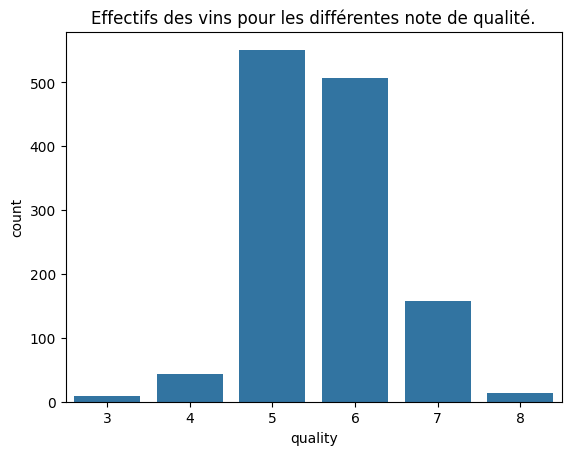

In [64]:
sns.countplot(data=train_set, x="quality")
plt.title("Effectifs des vins pour les différentes note de qualité.")
plt.show()

In [65]:
analyse_set = train_set.copy()
analyse_set["quality"].replace({3: 4, 8: 7}, inplace=True)
analyse_set["quality"].value_counts().sort_index()

/tmp/ipykernel_1410/2854978225.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  analyse_set["quality"].replace({3: 4, 8: 7}, inplace=True)


quality
4     52
5    551
6    506
7    170
Name: count, dtype: int64

On voit clairement que la qualité suit une loi normale. Pour la suite on va analyser toutes les variables en découpant chaque variable par type. Les variables d'acidité fixed acidity, volatile acidity, citric acid et pH. Les variables de concentrations en sucre et sel. Les variables de concentrations en molécule souffré qui contienne les variables free sulfur dioxide, total sulfur dioxide et sulphates. La variable de densité. On étudiera tous seul et en premier le pourcentage volumique en alcool car c'est l'élément centrale de toutes boisson alcoolisé. Dans un premier temps chaque analyse serat composé d'une analyse univarié puis d'une analyse de chaque variable avec la qualité. Si le modéle finale donne une performance insuffisant, on va ensuite regarder les relations entre les variables entre-eux pour trouver des moyens de créer de nouvelle variables. On va aussie à la fin de chaque analyse, analysé le vif totale pour choisir si on doit utilisé un modéle de ridge ou une régréssion linéaire classique.

## II.2) Le degré d'alcool

### II.2.1) Analyse univarié

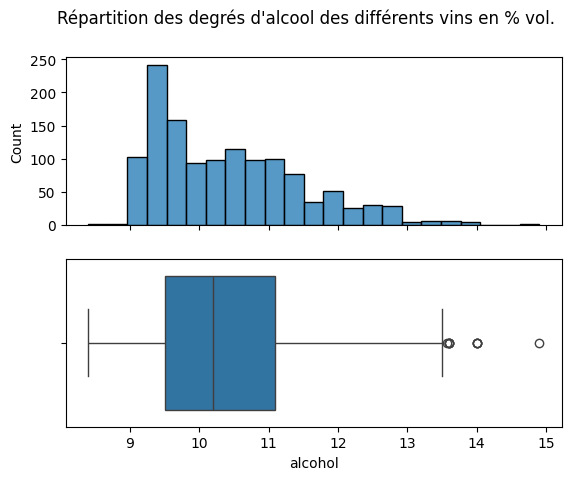

count    1279.000000
mean       10.418100
std         1.052694
min         8.400000
25%         9.500000
50%        10.200000
75%        11.100000
max        14.900000
Name: alcohol, dtype: float64

In [66]:
fig, ax = plt.subplots(2, 1, sharex=True)
plt.suptitle("Répartition des degrés d'alcool des différents vins en % vol.")
sns.histplot(data=analyse_set, x="alcohol", ax=ax[0])
sns.boxplot(data=analyse_set, x="alcohol", ax=ax[1])
plt.show()

analyse_set["alcohol"].describe()

Les vins rouges de type vhino verde portuguais de ce jeu de donnée ont en mopyenne un degrés d'alcool de 10.41 degrés qui est un degré plutôt normale. On voit que le minimum est de 8.4 qui est un vin trés peu alcooliser pour un vin. Le maximum à 14 degrés qui est un vin qui est considérée comme trés alcoolisé. On voit que l'alcool suit une loi normale et on observe des outliers à droite de la boxplot.

### II.2.2) Analyse multivarié

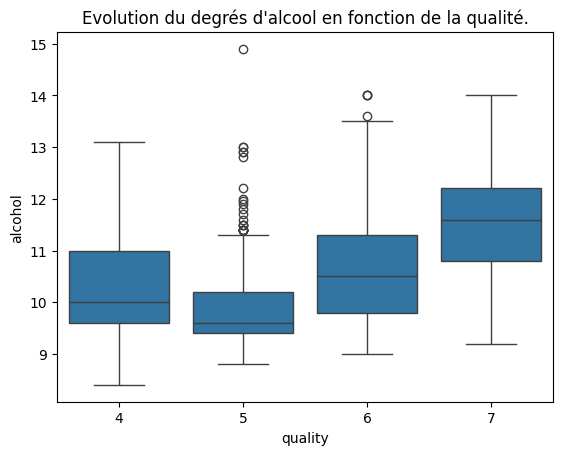

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,10.241346,0.948307,8.4,9.6,10.0,11.0,13.1
5,551.0,9.898548,0.732286,8.8,9.4,9.6,10.2,14.9
6,506.0,10.634157,1.022647,9.0,9.8,10.5,11.3,14.0
7,170.0,11.513039,1.001522,9.2,10.8,11.6,12.2,14.0


In [67]:
sns.boxplot(data=analyse_set, x="quality", y="alcohol")
plt.title("Evolution du degrés d'alcool en fonction de la qualité.")
plt.show()

analyse_set.groupby("quality")["alcohol"].describe()

On observe d'abords une diminution puis ensuite une augmentation des statistique de degré d'alcool. Pour tester cette évolution on va faire un test de ANOVA. Voici les conditions d'utilisation:

1) Tous les vins sont issues de la même population.

2) Le degrés d'alcool d'un vin ne dépends des autres.

3) Il y a plus de 3à points par groupes

4) Les écart-type sont assez similaires pour faire un test de ANOVA.

In [68]:
print("H0: Les degrés d'alcool en moyenne ne varie en fonction de la qualité.")

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["alcohol"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les degrés d'alcool en moyenne ne varie en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


Comme on a rejeter H0, on peut dire avec un seuil alpha de 2% qu'il y a a bien une variation du degré d'alcool en fonction de la qualité.

## II.3) Analyse des variables d'acidité.

### II.3.1) Analyse univarié

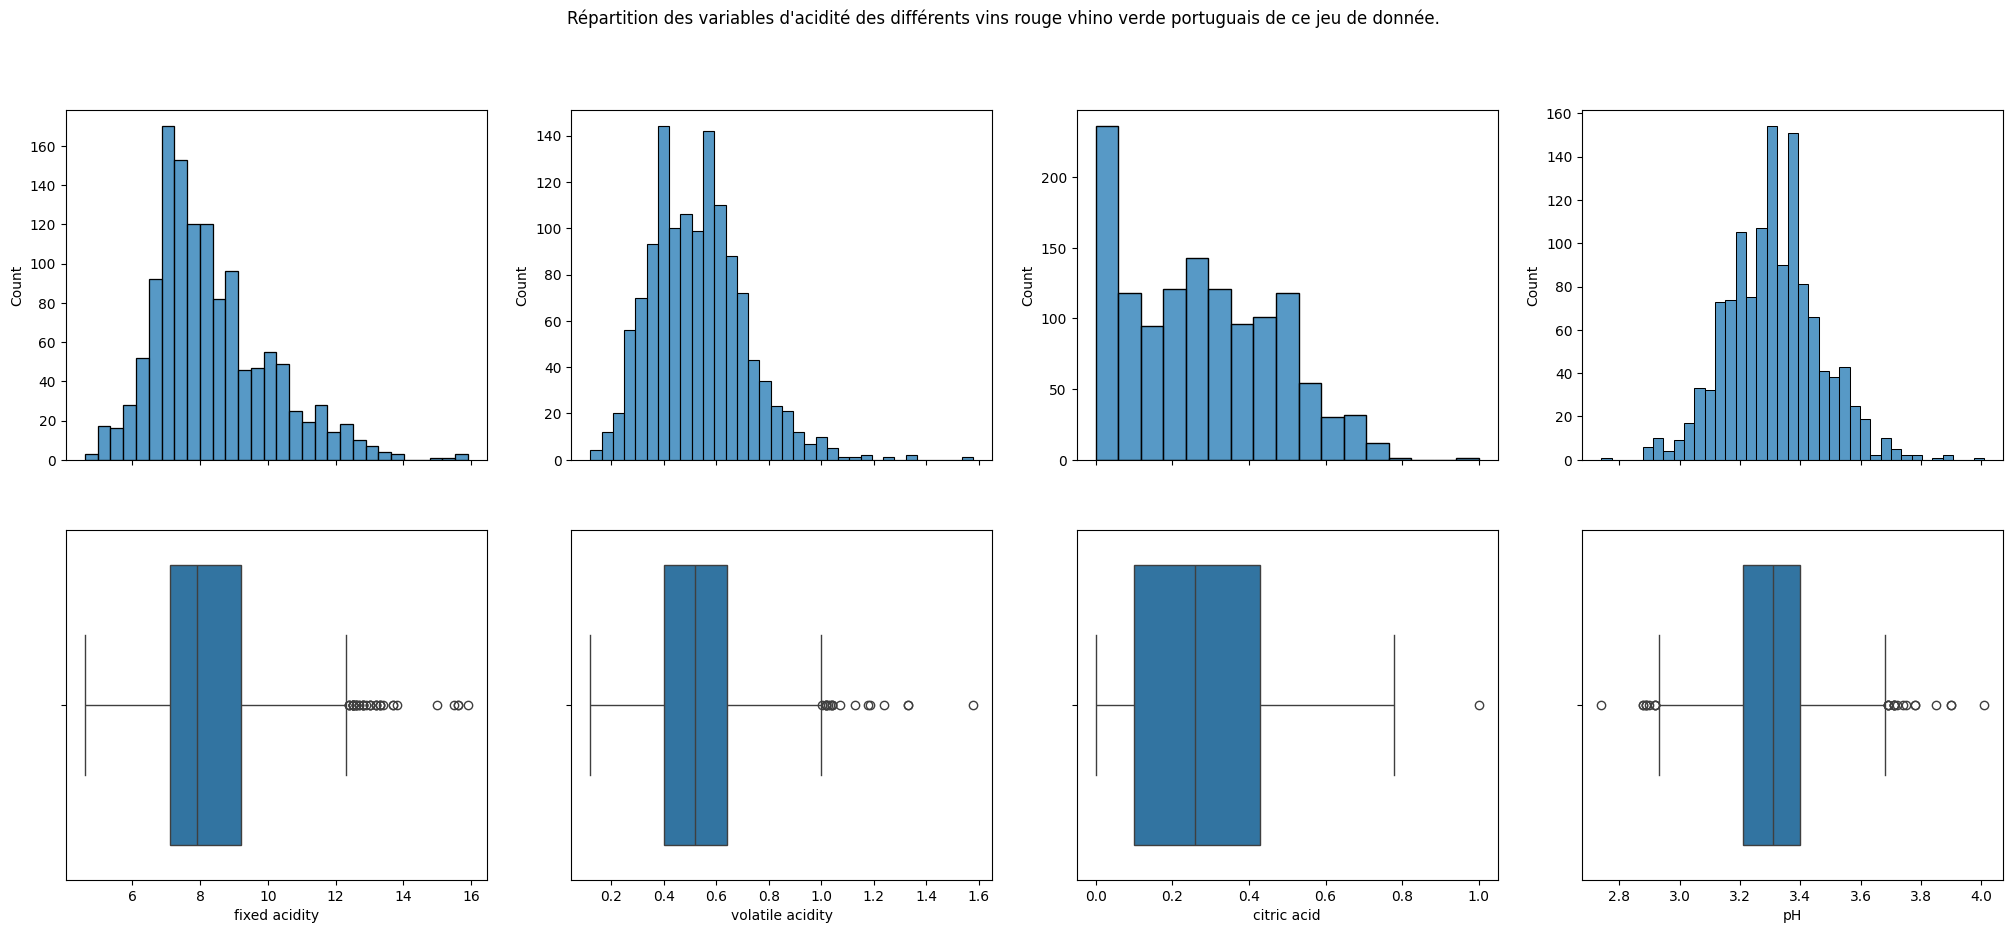

,fixed acidity,volatile acidity,citric acid,pH
count,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.323690,0.530559,0.272471,3.311650
std,1.724243,0.179275,0.195448,0.154016
min,4.600000,0.120000,0.000000,2.740000
25%,7.100000,0.400000,0.100000,3.210000
50%,7.900000,0.520000,0.260000,3.310000
75%,9.200000,0.640000,0.430000,3.400000
max,15.900000,1.580000,1.000000,4.010000


In [69]:
fig, ax = plt.subplots(2, 4, sharex="col")
fig.set_size_inches(25, 10)
plt.suptitle(
    "Répartition des variables d'acidité des différents vins rouge vhino verde portuguais de ce jeu de donnée."
)
sns.histplot(data=analyse_set, x="fixed acidity", ax=ax[0, 0])
sns.boxplot(data=analyse_set, x="fixed acidity", ax=ax[1, 0])
sns.histplot(data=analyse_set, x="volatile acidity", ax=ax[0, 1])
sns.boxplot(data=analyse_set, x="volatile acidity", ax=ax[1, 1])
sns.histplot(data=analyse_set, x="citric acid", ax=ax[0, 2])
sns.boxplot(data=analyse_set, x="citric acid", ax=ax[1, 2])
sns.histplot(data=analyse_set, x="pH", ax=ax[0, 3])
sns.boxplot(data=analyse_set, x="pH", ax=ax[1, 3])
plt.show()
analyse_set[["fixed acidity", "volatile acidity", "citric acid", "pH"]].describe()

Les vins vhino verde portuguais rouge de ce jeu de donnée ont en moyenne une acidité fixe, une acidité volatile, une concentration en acide citrique et un pH respectivement égale à 8.323690 g/dm3, 0.530559 g/dm3, 0.272471 g/dm3 et 3.311650. On peut dire que tous les vins sont acides car elles sont toutes en-dessous de 7. On observe que l'acidité fixe, volatile et le pH suivent une loi nomale et la concentration en acide citrique ne suit pas une loi normale. On observe des outliers à droite de chaque boxplot et aussi à gauche pour le pH. On observe qu'une grosse partie des vins n'ont pas d'acide citrique.

### II.3.2) Analyse multivarié avec la target

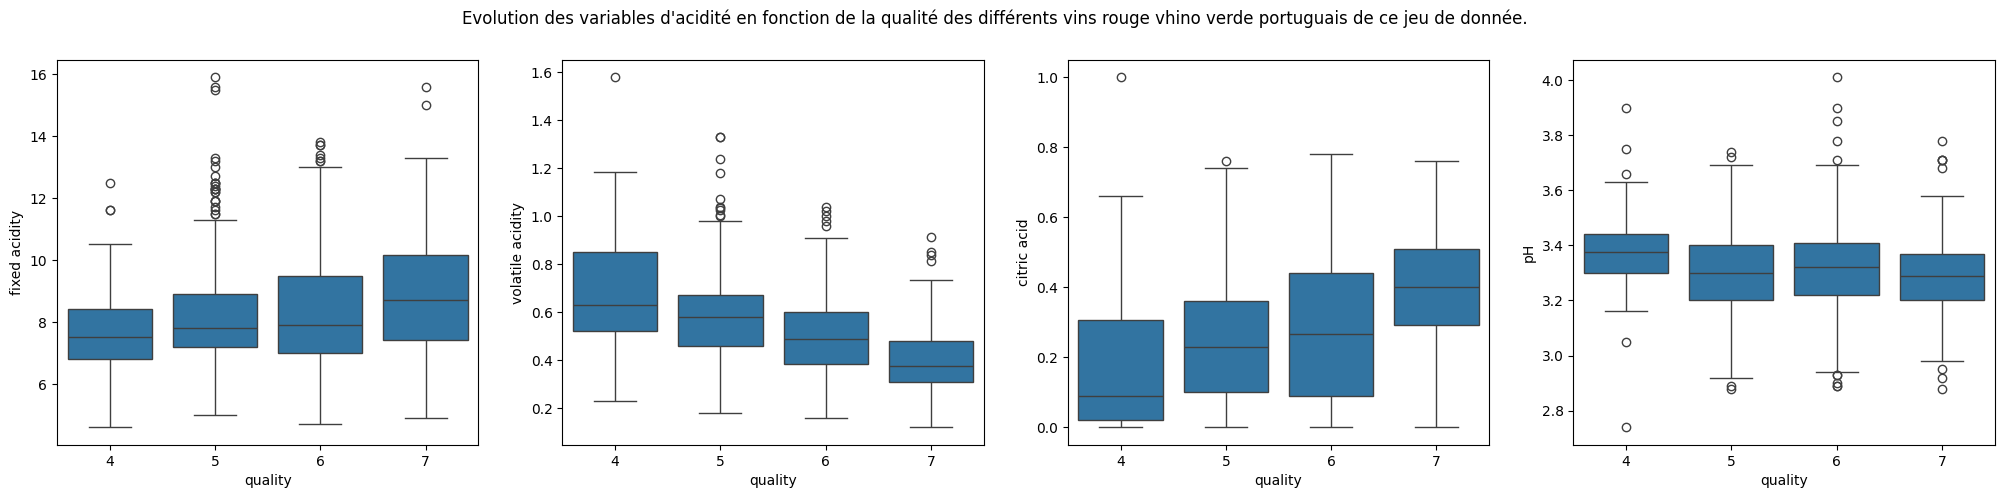

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,7.873077,1.672748,4.6,6.8,7.5,8.425,12.5
5,551.0,8.187296,1.526143,5.0,7.2,7.8,8.900,15.9
6,506.0,8.347036,1.807005,4.7,7.0,7.9,9.475,13.8
7,170.0,8.834118,1.978377,4.9,7.4,8.7,10.175,15.6


In [70]:
fig, ax = plt.subplots(1, 4)
fig.set_size_inches(25, 5)
plt.suptitle(
    "Evolution des variables d'acidité en fonction de la qualité des différents vins rouge vhino verde portuguais de ce jeu de donnée."
)
sns.boxplot(data=analyse_set, x="quality", y="fixed acidity", ax=ax[0])
sns.boxplot(data=analyse_set, x="quality", y="volatile acidity", ax=ax[1])
sns.boxplot(data=analyse_set, x="quality", y="citric acid", ax=ax[2])
sns.boxplot(data=analyse_set, x="quality", y="pH", ax=ax[3])
plt.show()
analyse_set.groupby("quality")["fixed acidity"].describe()

In [71]:
analyse_set.groupby("quality")["volatile acidity"].describe()

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,0.695481,0.255159,0.23,0.5200,0.630,0.8525,1.580
5,551.0,0.580163,0.168530,0.18,0.4600,0.580,0.6700,1.330
6,506.0,0.500603,0.159640,0.16,0.3825,0.490,0.6000,1.040
7,170.0,0.408500,0.144032,0.12,0.3100,0.375,0.4800,0.915


In [72]:
analyse_set.groupby("quality")["citric acid"].describe()

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,0.189038,0.215536,0.0,0.0200,0.090,0.305,1.00
5,551.0,0.245989,0.178087,0.0,0.1000,0.230,0.360,0.76
6,506.0,0.275277,0.196922,0.0,0.0900,0.265,0.440,0.78
7,170.0,0.375471,0.201591,0.0,0.2925,0.400,0.510,0.76


In [73]:
analyse_set.groupby("quality")["pH"].describe()

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,3.375000,0.177339,2.74,3.3000,3.375,3.4425,3.90
5,551.0,3.303702,0.149930,2.88,3.2000,3.300,3.4000,3.74
6,506.0,3.320316,0.154236,2.89,3.2200,3.320,3.4100,4.01
7,170.0,3.292235,0.153634,2.88,3.2025,3.290,3.3700,3.78


On voit clairement que l'acidité fixe et la concentration en acide citrique augmente en fonction de la qualité. Effectivement comme l'acide citrique ajoute de la fraicheur cela peut améliorer la qualité du vin. Pour l'acide tartrique comme on peut le citer dans le site https://chateauberne-vin.com/pages/definition/acide-tartrique#:~:text=Les%20vins%20contenant%20un%20niveau,et%20autres%20micro%2Dorganismes%20n%C3%A9fastes: "Les vins contenant un niveau optimal d’*acide tartrique* présentent plusieurs avantages distincts. Sur le plan gustatif, ils offrent une fraîcheur et une vivacité inégalées. En termes de stabilité, cet acide protège contre la croissance indésirable de bactéries et autres micro-organismes néfastes. Plus précisément, les caractéristiques affectées par l’acide tartrique incluent :

Acidité : Contribue à l’équilibre global.
Saveur : Améliore le profil aromatique.
Stabilité : Prévient la dégradation prématurée."

Donc c'est assez logique que ces deux variables sont importantes pour notre modéle. On observe une diminution de la qualité avec l'acidité volatile qui correspond en fait à la concentration en acide acétique qui donne un gout de vinaigre qui est désagréable. Donc c'est tout à fait logique que la qualité diminue avec l'acidité volatile. On ne voit pas de variation pour le pH. On va donc tester les variations avec un test de ANOVA. Condition:

1) Tous les vins issues de la même population

2) Tous les variables d'acidité d'un vin ne dépends des autres

3) On a bien plus de 30 vins par groupes de qualité

4) Les écart-types sont assez similaires pour faire des test de Anova pour les quatres variables d'acidité.

In [74]:
print("H0: Les acidité fixe en moyenne ne varie en fonction de la qualité.")

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["fixed acidity"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les acidité fixe en moyenne ne varie en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


In [75]:
print("H0: Les acidité volatile en moyenne ne varie en fonction de la qualité.")

alpha = 0.02

p_value = f_oneway(
    *analyse_set.groupby("quality")["volatile acidity"].apply(list)
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les acidité volatile en moyenne ne varie en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


In [76]:
print(
    "H0: Les concentration massique en acide citrique en moyenne ne varie en fonction de la qualité."
)

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["citric acid"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les concentration massique en acide citrique en moyenne ne varie en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


In [77]:
print("H0: Les pH en moyenne ne varie en fonction de la qualité.")

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["pH"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: Les pH en moyenne ne varie en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


Comme on a rejeter H0 pour les quatres variables, on peut dire qu'il y a bien une évolution des quatres variables d'acidité en fonction de la qualité. On va maintenant visualiser les relations entre les variables d'acidité entre-eux en affichant la qualité avec hue.

## II.4) Analyse des variables de concentration en sel et en sucre

### II.4.1) Analyse univarié 

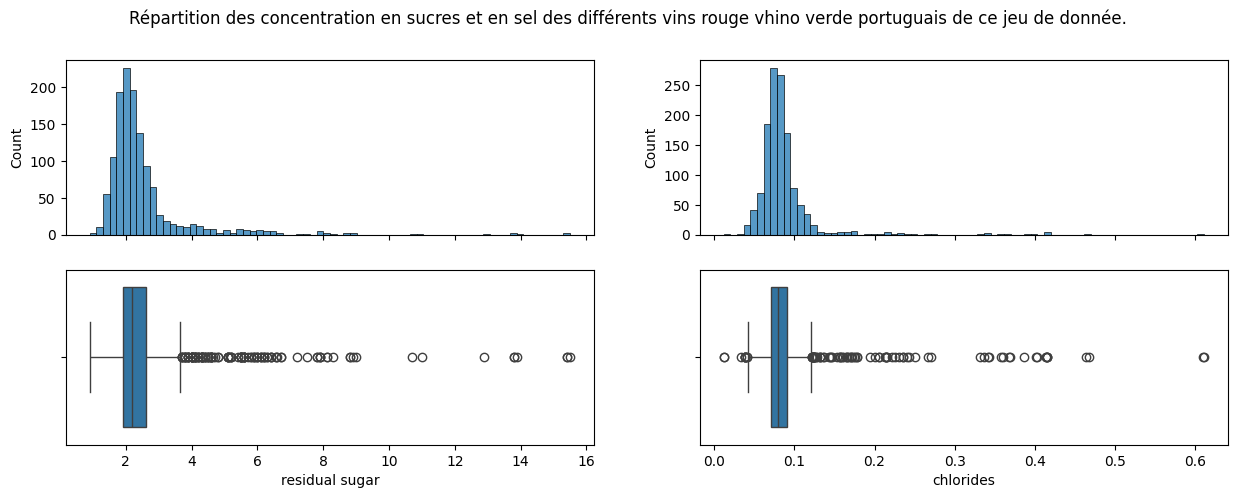

,residual sugar,chlorides
count,1279.000000,1279.000000
mean,2.555473,0.088448
std,1.435790,0.049332
min,0.900000,0.012000
25%,1.900000,0.071000
50%,2.200000,0.080000
75%,2.600000,0.091000
max,15.500000,0.611000


In [78]:
fig, ax = plt.subplots(2, 2, sharex="col")
fig.set_size_inches(15, 5)
plt.suptitle(
    "Répartition des concentration en sucres et en sel des différents vins rouge vhino verde portuguais de ce jeu de donnée."
)
sns.histplot(data=analyse_set, x="residual sugar", ax=ax[0, 0])
sns.boxplot(data=analyse_set, x="residual sugar", ax=ax[1, 0])
sns.histplot(data=analyse_set, x="chlorides", ax=ax[0, 1])
sns.boxplot(data=analyse_set, x="chlorides", ax=ax[1, 1])
plt.show()
analyse_set[["residual sugar", "chlorides"]].describe()

Les vins vhino verde rouge portuguais de ce jeu de donnée ont en moyenne une concentration en sucre résiduelle et en sel respectivement égale à 2.555473 g/l et 0.088448 g/l. Les deux variables suivent une loi normale avec une grosse série d'outliers à droite. On va maintenant visualiser les deux variables en fonction de la qualité.

### II.4.2) Analyse mutlivarié avec la target

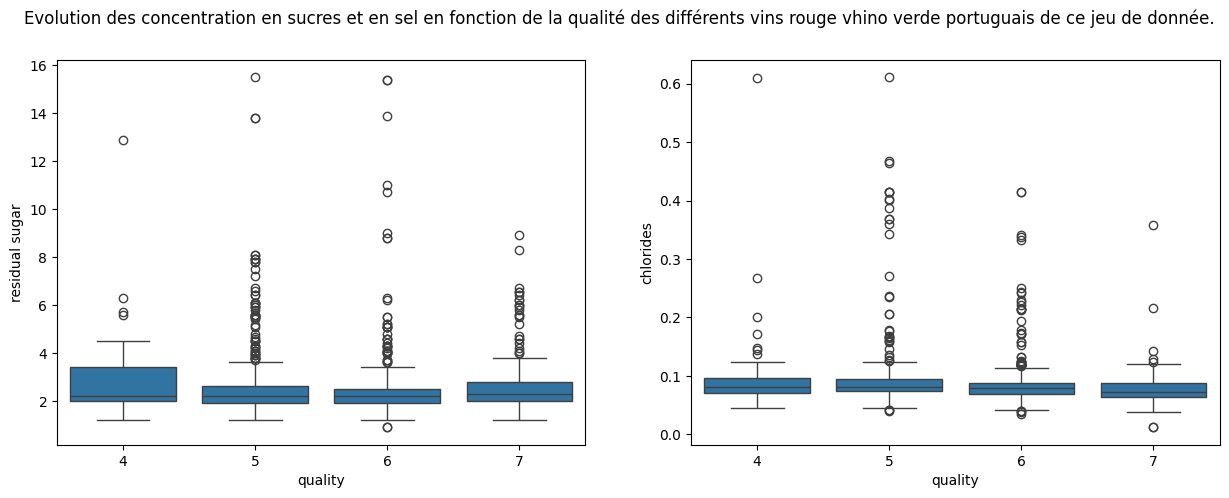

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,2.804808,1.860641,1.2,1.975,2.2,3.4,12.9
5,551.0,2.552995,1.430358,1.2,1.900,2.2,2.6,15.5
6,506.0,2.469170,1.410873,0.9,1.900,2.2,2.5,15.4
7,170.0,2.744118,1.364120,1.2,2.000,2.3,2.8,8.9


In [79]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)
plt.suptitle(
    "Evolution des concentration en sucres et en sel en fonction de la qualité des différents vins rouge vhino verde portuguais de ce jeu de donnée."
)
sns.boxplot(data=analyse_set, x="quality", y="residual sugar", ax=ax[0])
sns.boxplot(data=analyse_set, x="quality", y="chlorides", ax=ax[1])
plt.show()
analyse_set.groupby("quality")["residual sugar"].describe()

In [80]:
analyse_set.groupby("quality")["chlorides"].describe()

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,0.100231,0.081901,0.045,0.06975,0.0815,0.09625,0.610
5,551.0,0.093363,0.056328,0.039,0.07400,0.0810,0.09450,0.611
6,506.0,0.085678,0.040143,0.034,0.06900,0.0790,0.08800,0.415
7,170.0,0.077159,0.031078,0.012,0.06300,0.0725,0.08700,0.358


On ne voit pas de relation apparente entre la concentration en sucre résiduel et la qualité. On voit une légére diminution de la qualité en fonction de la concentration en sel. On va maintenant validé ces variations avec des tests de ANOVA.

In [81]:
print(
    "H0: La moyenne de concentration en sucre résiduel ne varie pas en fonction de la qualité."
)

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["residual sugar"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: La moyenne de concentration en sucre résiduel ne varie pas en fonction de la qualité.
Nous n'avons pas assez d'évidence pour rejeter H0.


In [82]:
print("H0: La moyenne de concentration en sel ne varie pas en fonction de la qualité.")

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["chlorides"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: La moyenne de concentration en sel ne varie pas en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


On voit qu'on n'a pas réussie à rejeter H0 pour le cas de la concentration en sucre résiduel. On peut donc dire que la qualité ne varia pas avec la concentration en sucre résiduel. Pour le cas de la concrntration en sel, on a réussie à rejeter H0, on peut donc dire qu'il y a bien une évolution de la concentration moyenne en sel avec la qualité.

## II.5) Analyse des variables de composé souffré

### II.5.1) Analyse univarié

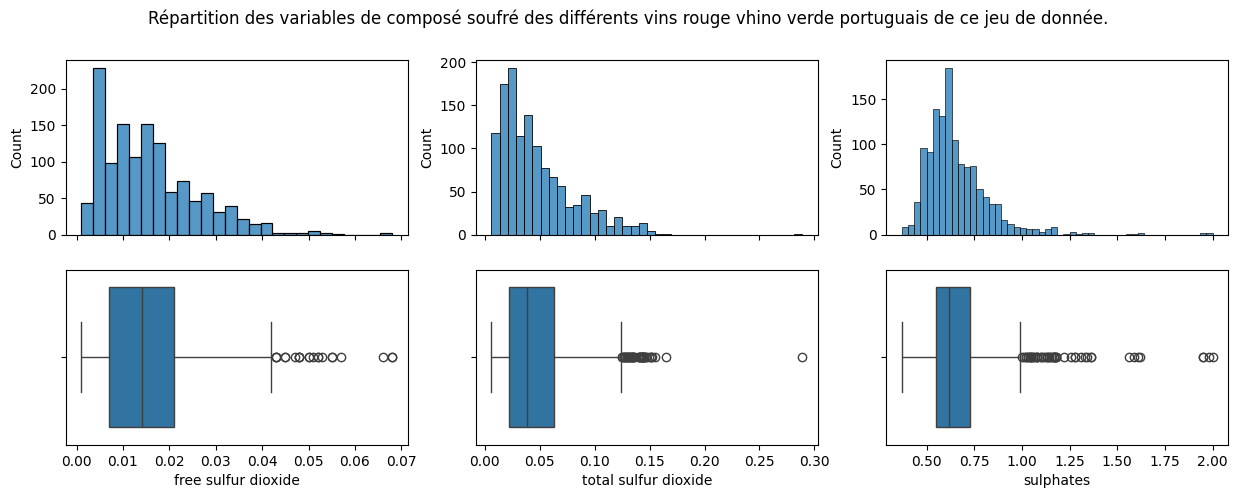

,free sulfur dioxide,total sulfur dioxide,sulphates
count,1279.000000,1279.000000,1279.000000
mean,0.015876,0.046657,0.660023
std,0.010314,0.032942,0.174605
min,0.001000,0.006000,0.370000
25%,0.007000,0.022000,0.550000
50%,0.014000,0.038000,0.620000
75%,0.021000,0.063000,0.730000
max,0.068000,0.289000,2.000000


In [83]:
fig, ax = plt.subplots(2, 3, sharex="col")
fig.set_size_inches(15, 5)
plt.suptitle(
    "Répartition des variables de composé soufré des différents vins rouge vhino verde portuguais de ce jeu de donnée."
)
sns.histplot(data=analyse_set, x="free sulfur dioxide", ax=ax[0, 0])
sns.boxplot(data=analyse_set, x="free sulfur dioxide", ax=ax[1, 0])
sns.histplot(data=analyse_set, x="total sulfur dioxide", ax=ax[0, 1])
sns.boxplot(data=analyse_set, x="total sulfur dioxide", ax=ax[1, 1])
sns.histplot(data=analyse_set, x="sulphates", ax=ax[0, 2])
sns.boxplot(data=analyse_set, x="sulphates", ax=ax[1, 2])
plt.show()
analyse_set[["free sulfur dioxide", "total sulfur dioxide", "sulphates"]].describe()

Les vins vhino verde rouges portuguais de ce jeu de données ont en moyenne une concentration en S02 libre, totale et une concentration en sulphates respectivement égale à 0.015876 g/l, 0.046657 g/l et 0.660023 g/l. On observe que seul la concentration totale de SO2 ne suit pas vraiment une loi normale. Sa serait une loi exponentielle. Pour les trois variable on observe des outliers à droite de la boxplot.

### II.5.2) Analyse multivairé avec la qualité

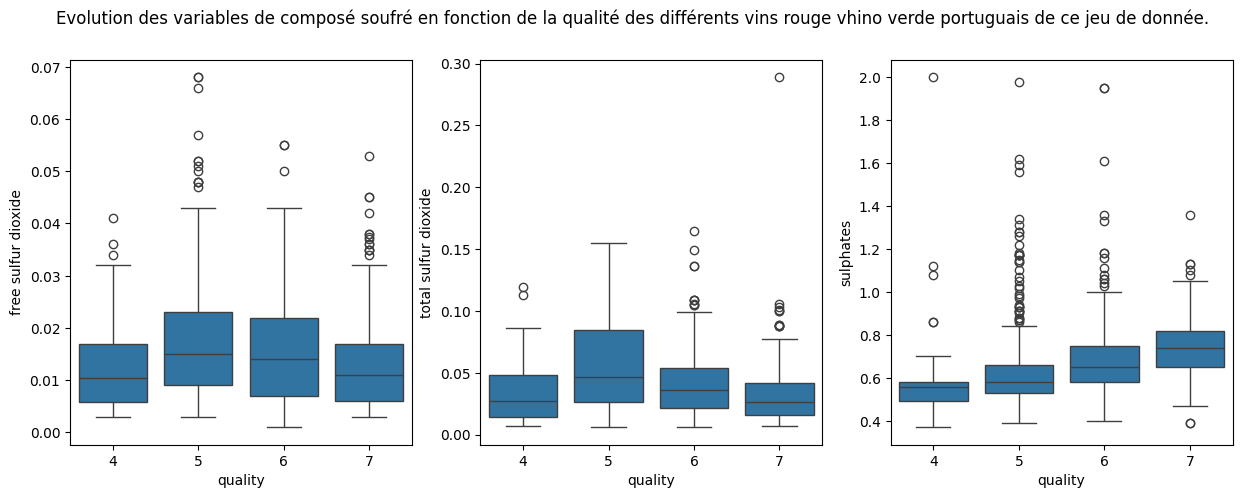

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,0.012769,0.009426,0.003,0.00575,0.0105,0.017,0.041
5,551.0,0.016866,0.010891,0.003,0.00900,0.0150,0.023,0.068
6,506.0,0.015844,0.009689,0.001,0.00700,0.0140,0.022,0.055
7,170.0,0.013715,0.010009,0.003,0.00600,0.0110,0.017,0.053


In [84]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
plt.suptitle(
    "Evolution des variables de composé soufré en fonction de la qualité des différents vins rouge vhino verde portuguais de ce jeu de donnée."
)
sns.boxplot(data=analyse_set, x="quality", y="free sulfur dioxide", ax=ax[0])
sns.boxplot(data=analyse_set, x="quality", y="total sulfur dioxide", ax=ax[1])
sns.boxplot(data=analyse_set, x="quality", y="sulphates", ax=ax[2])
plt.show()
analyse_set.groupby("quality")["free sulfur dioxide"].describe()

In [85]:
analyse_set.groupby("quality")["total sulfur dioxide"].describe()

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,0.036000,0.027302,0.007,0.01400,0.0275,0.04825,0.119
5,551.0,0.056954,0.037647,0.006,0.02600,0.0470,0.08500,0.155
6,506.0,0.040907,0.024856,0.006,0.02125,0.0360,0.05400,0.165
7,170.0,0.033659,0.029546,0.007,0.01625,0.0265,0.04200,0.289


In [86]:
analyse_set.groupby("quality")["sulphates"].describe()

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,0.597692,0.242379,0.37,0.49,0.555,0.58,2.00
5,551.0,0.622269,0.174736,0.39,0.53,0.580,0.66,1.98
6,506.0,0.679387,0.164018,0.40,0.58,0.650,0.75,1.95
7,170.0,0.743824,0.137957,0.39,0.65,0.740,0.82,1.36


On observe une augmentation de la concentration moyenne des deux type de SO2 et des autres statistiques de la qualité 4 à 5 puis ensuite il y une diminution. Par contre on a une belle augmentation linéaire des statsistiques de la concentration en sulphates en fonction de la qualité. Faisons les tests de Anova.

In [87]:
print(
    "H0: La moyenne de concentration en SO2 libre ne varie pas en fonction de la qualité."
)

alpha = 0.02

p_value = f_oneway(
    *analyse_set.groupby("quality")["free sulfur dioxide"].apply(list)
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: La moyenne de concentration en SO2 libre ne varie pas en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


In [88]:
print(
    "H0: La moyenne de concentration en SO2 totale ne varie pas en fonction de la qualité."
)

alpha = 0.02

p_value = f_oneway(
    *analyse_set.groupby("quality")["total sulfur dioxide"].apply(list)
).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: La moyenne de concentration en SO2 totale ne varie pas en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


In [89]:
print(
    "H0: La moyenne de concentration en sulphates ne varie pas en fonction de la qualité."
)

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["sulphates"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: La moyenne de concentration en sulphates ne varie pas en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


Sans surprise on à rejeter H0 pour les trois variables de composé souffré. On peut donc dire qu'il y a bien une variation de la qualité en fonction de la concentration des trois composé soufré.

## II.6) Analyse de la densité

### II.6.1) Analyse univarié

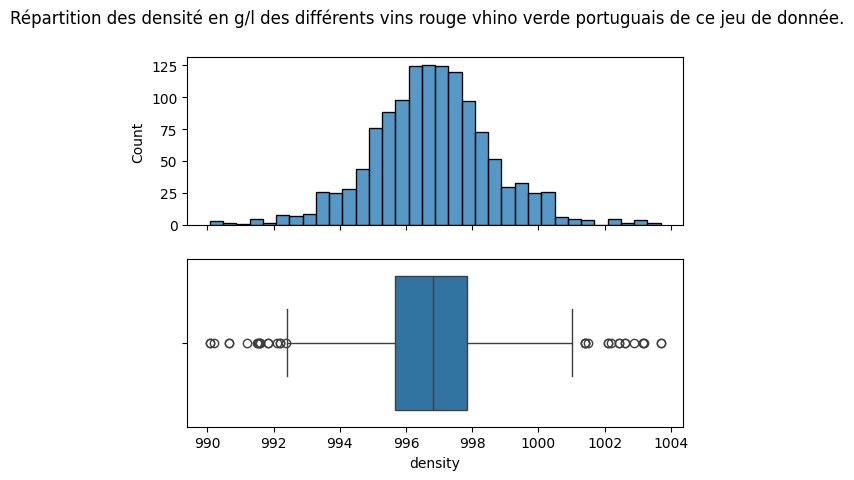

count    1279.000000
mean      996.773980
std         1.855941
min       990.070000
25%       995.655000
50%       996.800000
75%       997.845000
max      1003.690000
Name: density, dtype: float64

In [90]:
fig, ax = plt.subplots(2, 1, sharex="col")
plt.suptitle(
    "Répartition des densité en g/l des différents vins rouge vhino verde portuguais de ce jeu de donnée."
)
sns.histplot(data=analyse_set, x="density", ax=ax[0])
sns.boxplot(data=analyse_set, x="density", ax=ax[1])
plt.show()
analyse_set["density"].describe()

Les vins vhino verde rouge portuguais de ce jeu de donnée ont une densité moyenne de 996.773980 g/l qui est proche de 1000 g/l qui est la densité de l'eau. On pourrat ainsi tester cette hypothése. On observe que la densité suit une belle loi normale et il y a des outliers à droite et à gauche de la boxplot. Testons maintenant l'hypothése que les vins vhino verde de ce jeu de données ont en moyenne une densité similaire à l'eau.

In [91]:
print(
    "H0: La densité des vins de ce jeu de donnée est en moyenne égale à celle de l'eau."
)

alpha = 0.02

p_value = ttest_1samp(analyse_set["density"], popmean=1000).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: La densité des vins de ce jeu de donnée est en moyenne égale à celle de l'eau.
Nous avons assez d'évidences pour rejeter H0.


Comme H0 à été rejeter on peut dire que la densité des vins de ce jeu de données n'est pas égale à celle de l'eau.

### II.6.2) Analyse multivarié avec la target

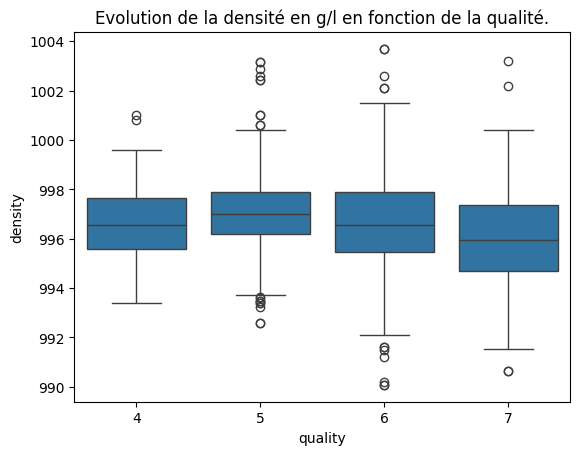

,count,mean,std,min,25%,50%,75%,max
quality,,,,,,,,
4,52.0,996.646538,1.707247,993.40,995.5925,996.56,997.65,1001.00
5,551.0,997.129328,1.548907,992.56,996.2000,997.00,997.90,1003.15
6,506.0,996.636028,1.989780,990.07,995.4425,996.56,997.90,1003.69
7,170.0,996.071824,2.135444,990.64,994.7000,995.93,997.36,1003.20


In [92]:
sns.boxplot(data=analyse_set, x="quality", y="density")
plt.title("Evolution de la densité en g/l en fonction de la qualité.")
plt.show()
analyse_set.groupby("quality")["density"].describe()

On observe une légére augmentation puis une légére diminution des statistiques de la densité. Maintenant testons cette observation avec un test de Anova.

In [93]:
print("H0: La moyenne de densité ne varie pas en fonction de la qualité.")

alpha = 0.02

p_value = f_oneway(*analyse_set.groupby("quality")["density"].apply(list)).pvalue

if p_value < alpha:
    print("Nous avons assez d'évidences pour rejeter H0.")
else:
    print("Nous n'avons pas assez d'évidence pour rejeter H0.")

H0: La moyenne de densité ne varie pas en fonction de la qualité.
Nous avons assez d'évidences pour rejeter H0.


Comme on a rejeter H0, on peut donc dire qu'il y a bien une variation de la densité en fonction de la qualité. Maintenant avant de continuer on va calculer le vif avec toutes les variables qu'on a sélectionner.

In [94]:
def compute_vif(df: pd.DataFrame) -> pd.DataFrame:
    Xc = df.select_dtypes(include=[np.number]).dropna()
    vifs = [variance_inflation_factor(Xc.values, i) for i in range(Xc.shape[1])]
    out = pd.DataFrame({"variable": Xc.columns, "VIF": vifs})
    return out[out["variable"] != "const"].sort_values("VIF", ascending=False)


compute_vif(analyse_set.drop(["residual sugar", "quality"], axis=1))

,variable,VIF
6,density,1469.816191
7,pH,1067.880484
9,alcohol,128.610116
0,fixed acidity,74.968019
8,sulphates,20.797544
1,volatile acidity,17.304670
2,citric acid,9.357625
5,total sulfur dioxide,6.561435
4,free sulfur dioxide,6.536818
3,chlorides,6.369285


On a une explosion du vif pour la variable densité et le pH. Il faudrat donc utiliser le modéle de Ridge.

# III) Premier modéle

Comme dans notre jeu de données on n'a que des variables continues, il n' y a pas d'étapes d'encoding. On va directement faire de la normalisation. Pour choisire les techniques de normalisation, on va d'abords tester les quatre techniques, minmax, standardisation, Robust et maxabs. On partira de la méthode qui donnera le meilleur score sur le jeu de test puis on changera la technique de normalisation de chaque variable un à un en tester les trois teshniques. 

In [95]:
X_train = train_set.drop(["residual sugar", "quality"], axis=1)
y_train = train_set["quality"]
X_train

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
493,8.7,0.690,0.31,0.086,0.0230,0.081,1000.20,3.48,0.74,11.6
354,6.1,0.210,0.40,0.066,0.0405,0.165,991.20,3.25,0.59,11.9
342,10.9,0.390,0.47,0.118,0.0060,0.014,998.20,3.30,0.75,9.8
834,8.8,0.685,0.26,0.088,0.0160,0.023,996.94,3.32,0.47,9.4
705,8.4,1.035,0.15,0.073,0.0110,0.054,999.00,3.37,0.49,9.9
...,...,...,...,...,...,...,...,...,...,...
1130,9.1,0.600,0.00,0.058,0.0050,0.010,997.70,3.18,0.63,10.4
1294,8.2,0.635,0.10,0.073,0.0250,0.060,996.38,3.29,0.75,10.9
860,7.2,0.620,0.06,0.077,0.0150,0.085,997.46,3.51,0.54,9.5
1459,7.9,0.200,0.35,0.054,0.0070,0.015,994.58,3.32,0.80,11.9


In [96]:
minmax_normaliser = make_pipeline(MinMaxScaler())
standard_normaliser = make_pipeline(StandardScaler())
maxabs_normaliser = make_pipeline(MaxAbsScaler())
robust_normaliser = make_pipeline(RobustScaler())

X_minmax = minmax_normaliser.fit_transform(X_train)
X_standard = standard_normaliser.fit_transform(X_train)
X_maxabs = maxabs_normaliser.fit_transform(X_train)
X_robust = robust_normaliser.fit_transform(X_train)

alphas = np.logspace(-6, 6, 25)

param_grid = [
    {"solver": ["auto", "svd", "lsqr"], "alpha": alphas},
    {
        "solver": ["sag"],
        "alpha": alphas,
        "tol": [1e-3, 1e-4],
        "max_iter": [2000, 10000],
    },
]

grid = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

grid.fit(X_minmax, y_train)
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_
y_train_pred = model.predict(X_minmax)
mean_absolute_error(y_train, y_train_pred)

{'alpha': np.float64(1.0), 'solver': 'lsqr'}
-0.43755251217771446


0.5009828926272425

In [97]:
X_test = test_set.drop(["residual sugar", "quality"], axis=1)
y_test = test_set["quality"]
X_test_minmax = minmax_normaliser.transform(X_test)
y_test_pred = model.predict(X_test_minmax)
mean_absolute_error(y_test, y_test_pred)

0.5069223281978387

In [98]:
grid.fit(X_standard, y_train)
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_
y_train_pred = model.predict(X_standard)
mean_absolute_error(y_train, y_train_pred)

{'alpha': np.float64(100.0), 'solver': 'svd'}
-0.43782390429253804


0.5025248667030268

In [99]:
X_test_standard = standard_normaliser.transform(X_test)
y_test_pred = model.predict(X_test_standard)
mean_absolute_error(y_test, y_test_pred)

0.5079366397240413

In [100]:
grid.fit(X_maxabs, y_train)
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_
y_train_pred = model.predict(X_maxabs)
mean_absolute_error(y_train, y_train_pred)

/home/florian/WineQualityPrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/florian/WineQualityPrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/florian/WineQualityPrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/florian/WineQualityPrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/florian/WineQualityPrediction/.venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did 

{'alpha': np.float64(0.31622776601683794), 'max_iter': 2000, 'solver': 'sag', 'tol': 0.001}
-0.4377635000328917


0.501274883488762

In [101]:
X_test_maxabs = maxabs_normaliser.transform(X_test)
y_test_pred = model.predict(X_test_maxabs)
mean_absolute_error(y_test, y_test_pred)

0.5059198434283994

In [102]:
grid.fit(X_robust, y_train)
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_
y_train_pred = model.predict(X_robust)
mean_absolute_error(y_train, y_train_pred)

{'alpha': np.float64(31.622776601683793), 'solver': 'auto'}
-0.4380006488933904


0.5014823107939418

In [103]:
X_test_robust = robust_normaliser.transform(X_test)
y_test_pred = model.predict(X_test_robust)
mean_absolute_error(y_test, y_test_pred)

0.5060205371066712

En testant chaque méthodes, on voit que c'est la normalisation MaxAbs qui donne le meilleur résultat. On va donc partir de ce normaliser et ensuite on va tester chaque méthodes en déplacant un à un les variables. Seul le meilleur normaliser serat montrer.

In [104]:
normaliser = ColumnTransformer(
    [
        (
            "MaxAbs",
            MaxAbsScaler(),
            [
                "fixed acidity",
                "free sulfur dioxide",
                "density",
            ],
        ),
        (
            "standard",
            StandardScaler(),
            ["volatile acidity", "citric acid", "total sulfur dioxide"],
        ),
        (
            "robust",
            RobustScaler(),
            ["chlorides", "pH", "sulphates"],
        ),
        ("minmax", MinMaxScaler(), ["alcohol"]),
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

X_train_norm = normaliser.fit_transform(X_train)
grid.fit(X_train_norm, y_train)
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_
y_train_pred = model.predict(X_train_norm)
mean_absolute_error(y_train, y_train_pred)

{'alpha': np.float64(1e-06), 'max_iter': 2000, 'solver': 'sag', 'tol': 0.001}
-0.4376650138726365


0.5005625199529775

In [105]:
X_test_norm = normaliser.transform(X_test)
y_test_pred = model.predict(X_test_norm)
mean_absolute_error(y_test, y_test_pred)

0.5041012263629469

On voit que le normaliser optimiser contient les quatres méthodes. On trouve finalement aprés optimisation du normaliser, un score trés proche de l'objectifs pour le train set et aussi pour le test set mais cela reste insuffisant. On observe que malgré l'explosion du vif, il n' y a pas trop d'overfitting grâce à la régréssion ridge et la cross validation. On va essayer maintenant d'utiliser un algorithme de KneighborRegressor.

In [108]:
param_grid = [
    {  # minkowski, on balaie p
        "n_neighbors": [3, 5, 7, 9, 11, 15, 21, 31, 41],
        "weights": ["uniform", "distance"],
        "metric": ["minkowski"],
        "p": [1, 2, 3],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "leaf_size": [15, 30, 45, 60],
    },
    {  # chebyshev, pas de p
        "n_neighbors": [3, 5, 7, 11, 15, 21, 31],
        "weights": ["uniform", "distance"],
        "metric": ["chebyshev"],
        "algorithm": ["auto", "kd_tree", "brute"],
        "leaf_size": [15, 30, 45],
    },
]

grid = GridSearchCV(
    estimator=KNeighborsRegressor(n_jobs=-1),
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
)

grid.fit(X_train_norm, y_train)
print(grid.best_params_)
print(grid.best_score_)
model = grid.best_estimator_

{'algorithm': 'auto', 'leaf_size': 15, 'metric': 'minkowski', 'n_neighbors': 21, 'p': 1, 'weights': 'distance'}
-0.3806157091570586


In [109]:
X_test_norm = normaliser.transform(X_test)
y_test_pred = model.predict(X_test_norm)
mean_absolute_error(y_test, y_test_pred)

0.4131699619451899

On observe cette fois-ci un peu plus d'overfitting mais on n'a atteint l'objectif sur le jeu de test. Maintenant on va visualiser la répartition des erreurs.

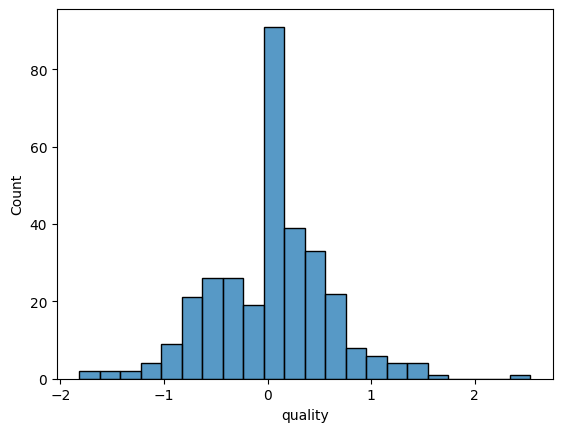

In [ ]:
differences = y_test_pred - y_test
sns.histplot(differences)
plt.show()

On a globalement des erreurs entre -1 et 1 avec une majorité trés proche de 0. On observe tous de même quelque valeur au delà de l'intervalle -1 et 1. Regardons le pourcentage d'erreur au-dessus de 0.5.

In [ ]:
differences_problématique = np.where(np.abs(differences) > 0.5)
(len(differences_problématique) / len(differences)) * 100

0.3125

On a 0.31 % de valeur au delà de l'intervalle cible ce qui fait que notre modéle est acceptable. On va maintenant faire un intervalle de confiance à 99%.

In [ ]:
se = np.std(differences) / np.sqrt(len(test_set))
mae = mean_absolute_error(y_test, y_test_pred)
z = 2.576
intervalle = [mae - z * se, mae + z * se]
intervalle

[np.float64(0.33077664466224693), np.float64(0.49556327922813287)]

La véritable erreur moyenne a 99% de chance d'être situé entre 0.331 et 0.496 soit strictement en-dessous de 0.5. On en conclut donc qu'on à 99% de chance que notre modéle ne se trompe pas sur la qualité aprés l'arrondie de nos prédictions. On sait déjà que ce modéle s'applique à des vins rouge vhino verde portuguai. On va maintenant regarder les erreurs par qualité.

/tmp/ipykernel_1410/3259988818.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(results, x="y_test", y="diff_round", palette="tab10")


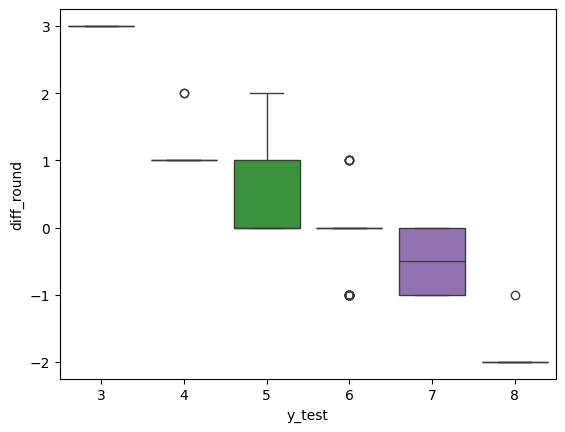

In [146]:
results = pd.DataFrame({"y_test": y_test, "diff_round": y_test_pred.round() - y_test})
sns.boxplot(results, x="y_test", y="diff_round", palette="tab10")
plt.show()

Notre modéle à tendence à faire plus d'erreur sur les vins qui ont le moins d'éffectifs, c'est-à-dire les vins trés mauvais et les vins trés bon.